In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from keras.src.callbacks.history import History

import plotly.express as px

from sklearn.metrics import confusion_matrix

In [2]:
def plot_results(history: History):
    """
    Plots model accuracy vs epoch AND model loss vs epoch (for train and validation data).
    Args:
        history (Keras History Object): this is the Keras's History object returned when running model.fit()
    Returns:
        None 
    """
    # training & validation accuracy values
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy vs Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(loc='upper left')

    # training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss vs Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()


# Inputs

In [3]:
# download and prep the data
protein_data = np.load('../data/cath_3class_ca.npz')

X_train_val, X_test, y_train_val, y_test = train_test_split(protein_data['positions'], protein_data['labels'], test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2)

# format train set
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
y_train = to_categorical(y_train-1)

# format val set
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1] * X_val.shape[2]))
y_val = to_categorical(y_val-1)

# format test set
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1] * X_test.shape[2]))
y_test = to_categorical(y_test-1)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(12212, 3606)
(12212, 3)
(3053, 3606)
(3053, 3)
(1697, 3606)
(1697, 3)


In [4]:
# 16962 proteins in the dataset
# each column repreesnting a single c-a position for an amino acid for the protein
  # 1202 is the max number of atoms within a protein in the dataset
  # therefore, a protein with only 10 AAs and 10 c-a positions is mostly a sparse matrix
# 3 is the dimension for the (x,y, z) coords
protein_data['positions'].shape

(16962, 1202, 3)

In [5]:
# looking at a single protein, it has shape of 1202 max atoms x 3 (for 3D positions)
protein_data['positions'][0].shape

(1202, 3)

In [6]:
# the 1st protein in the dataset only has 176 AAs
protein_data['n_atoms'][0]

np.int64(176)

In [7]:
# further inspecting the first protein with 176
# the majoiruty of the (x, y, z) coords are 0 vectors
protein_data['positions'][0]

array([[-0.46251011, 14.0216713 , -0.11604881],
       [ 2.52248955, 14.92267227,  2.01995087],
       [ 0.57148933, 16.07967186,  5.23795128],
       ...,
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

In [8]:
protein_data['positions'].shape

(16962, 1202, 3)

In [9]:
protein_data['labels']

array([[1],
       [1],
       [1],
       ...,
       [3],
       [3],
       [3]])

# Plotting the Proteins

In [10]:
def plot_proteins(num_protein: int, protein_positions: np.ndarray, protein_lables: np.ndarray, predicted_label: np.ndarray = None):
    """
    Returns multiple figures, given the number of proteins as
    input. This function randomly selects original (x,y,z) coords
    from the data and plots the 3D structure, index #, and secondary
    protein class structure. 
    Args:
        num_protein (int): number of proteins to plot
        protein_positions (np.ndarray): (x,y,z) coords of protein 
        protein_lables (np.ndarray): Secondary structure label
        predicted_label (np.ndarray, optional): Predicted lables, defaults to None
    """
    class_types_str = ['Mainly Alpha', 'Mainly Beta', 'Alpha-Beta']

    protein_indices = [np.random.randint(0, len(protein_positions)) for _ in range(num_protein)]
    
    for protein_num in protein_indices:
        class_type_int = protein_lables[protein_num][0] - 1
        fig = px.scatter_3d(
            x=protein_positions[protein_num, :, 0],
            y=protein_positions[protein_num, :, 1],
            z=protein_positions[protein_num, :, 2],
        )

        if predicted_label is not None:
            predicted_label_index = predicted_label[protein_num]
            fig.update_layout(
                title=f"Predicted 3D Structure of Protein #{protein_num}: '{class_types_str[predicted_label_index]}' (True Class: '{class_types_str[class_type_int]})",
                scene=dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z'
                )
            )                
        else:
            fig.update_layout(
                title=f"3D Structure of Protein #{protein_num} of Class: '{class_types_str[class_type_int]}'",
                scene=dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z'
                )
            )

        fig.show()


plot_proteins(num_protein=1, protein_positions=protein_data['positions'], protein_lables=protein_data['labels'])

# Class Distribution

In [11]:
# even class distribution
pd.Series(protein_data['labels'].flatten()).value_counts()

1    5654
2    5654
3    5654
Name: count, dtype: int64

# Data Pre-process
X_train: Flatten Positional Data for NN

- 12212 atoms in train set
- Flatten (3 x 1202) to a 1D vector = 3606
  - This vector keeps the 3D spatial coordiantes but in a single 1D vector input

In [12]:
X_train.shape

(12212, 3606)

In [13]:
X_train.shape[0]

12212

In [14]:
X_train[0]

array([ 5.23092651, -9.0918045 , 40.2350769 , ...,  0.        ,
        0.        ,  0.        ])

y_train: Categorical 
- Each lable contains a vector of length 3, that contains a binary value at the index of the correct label

In [15]:
y_train.shape

(12212, 3)

In [16]:
y_train[:3]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In this case,

- Protein 1 is Class 3 (aka Alpha-Beta)
- Protein 2 is Class 1 (aka Mainly Alpha)
- Protein 3 is Class 2 (aka Mainly Beta)

In [17]:
# 1: Basic Neural Network with one Layer, 4 Neurons in the Hidden Layer

model = keras.Sequential([
    layers.Dense(4, activation="relu"),
    layers.Dense(3, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
history = model.fit(X_train,
          y_train,
          epochs=20,
          batch_size=128,
          validation_data=(X_val, y_val))

# predict on test and evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")


Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3372 - loss: 1.7036 - val_accuracy: 0.3528 - val_loss: 1.3997
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3720 - loss: 1.2563 - val_accuracy: 0.3551 - val_loss: 1.3460
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3786 - loss: 1.2042 - val_accuracy: 0.3538 - val_loss: 1.2464
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3948 - loss: 1.1430 - val_accuracy: 0.3836 - val_loss: 1.2303
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4022 - loss: 1.1266 - val_accuracy: 0.3750 - val_loss: 1.2251
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4216 - loss: 1.0980 - val_accuracy: 0.3839 - val_loss: 1.1511
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4280 - loss: 1.0670 - val_accuracy: 0.4035 - val_loss: 1.1495
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4431 - loss: 1.0469 - val_accuracy: 0.3999 - val_loss:

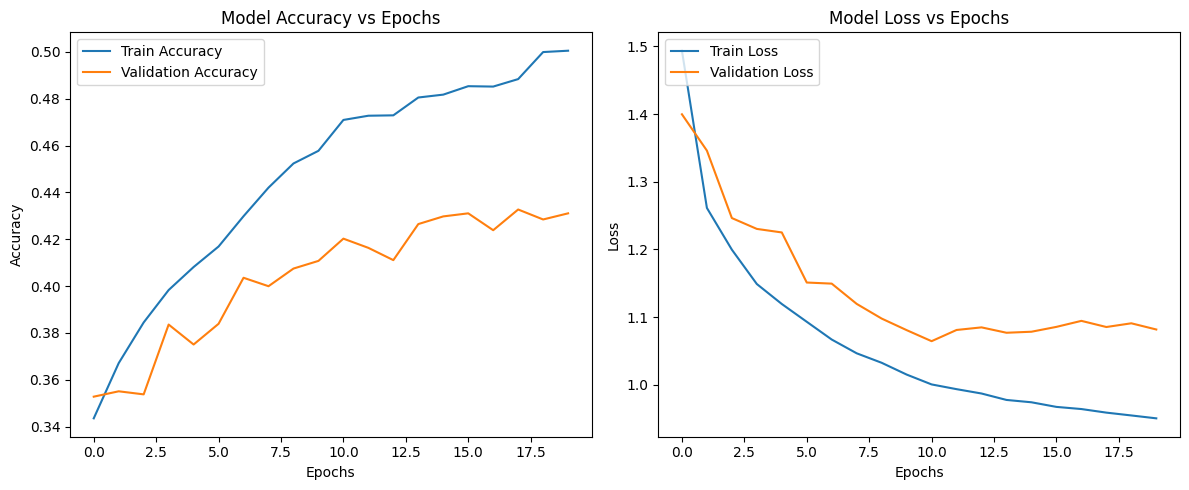

In [18]:
plot_results(history)

In [19]:
# 2: Basic Neural Network, 2 Hidden layers, 64 Neurons each - Prof's base

model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(3, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
history = model.fit(X_train,
          y_train,
          epochs=20,
          batch_size=128,
          validation_data=(X_val, y_val))

# predict on test and evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")


Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4077 - loss: 1.6155 - val_accuracy: 0.4998 - val_loss: 1.2152
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5652 - loss: 0.9766 - val_accuracy: 0.5044 - val_loss: 1.3076
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6544 - loss: 0.8212 - val_accuracy: 0.5545 - val_loss: 1.0971
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6894 - loss: 0.7244 - val_accuracy: 0.5673 - val_loss: 1.1244
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7315 - loss: 0.6351 - val_accuracy: 0.5866 - val_loss: 1.1336
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7537 - loss: 0.5848 - val_accuracy: 0.5853 - val_loss: 1.1046
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7699 - loss: 0.5346 - val_accuracy: 0.5929 - val_loss: 1.2305
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7972 - loss: 0.4867 - val_accuracy: 0.6076 - val_loss:

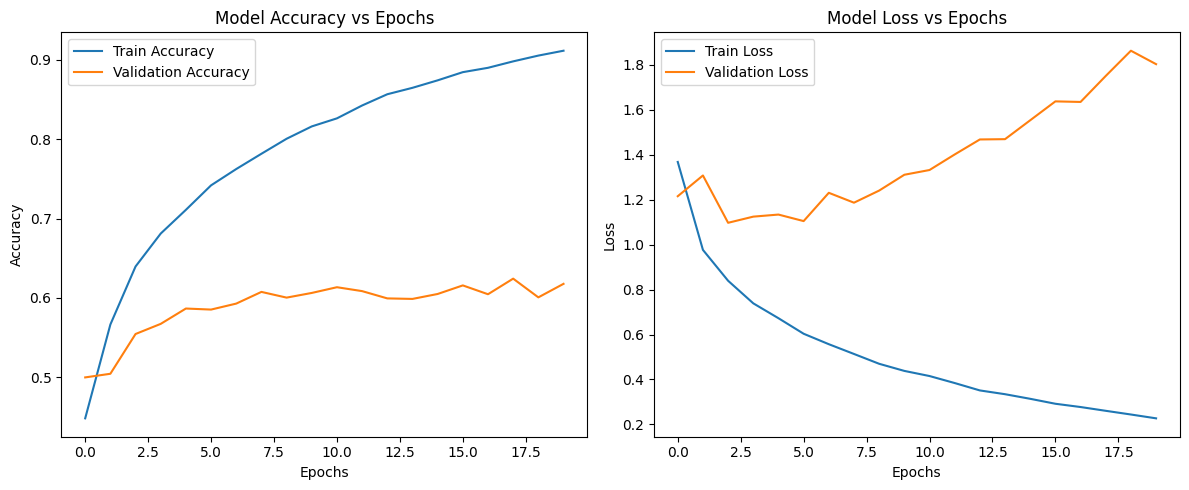

In [20]:
plot_results(history)

In [21]:
# 3. CNN - Experimental

# https://www.youtube.com/watch?v=pj9-rr1wDhM

# positions tensor for 3D CNN input requires different pre-processing
# protein_data['positions'].shape : (16962, 1202, 3)
    # 1. protein_data['positions'] converted to tensor (tensor_positions)
        # shape: TensorShape([16962, 1202, 3])
    # 2. tensor_positions gets an added channel dimension
        # commmon practice in image/batch processing and helps to optimize broadcasting/vector operations between tensors
        # need to look into the utility/theory of this more
        # shape: TensorShape([16962, 1202, 3, 1])
    # 3. tensor_positions gets an added spatial dimension
        # this transformation prepares the tensor specifically for a 3D convolution (?)
        # the added dimension apparently increases model expression/ability to learn more complex features
        # im not fully sure about the fundamental aspects of this, but have continued with it
        # also not sure the experimental value of where to place the new dimension (axis=2 vs other)
        # final shape: TensorShape([16962, 1202, 1, 3, 1])
    # overall, the theory/math behind these pre-processing steps needs to be further understood/explored

tensor_positions = tf.convert_to_tensor(protein_data['positions'], dtype=tf.float32)
tensor_positions = tf.expand_dims(tensor_positions, axis=-1)  
tensor_positions = tf.expand_dims(tensor_positions, axis=2)  

# convert labels to tensors of shape TensorShape([16962, 3])
tensor_labels = tf.convert_to_tensor(protein_data['labels'], dtype=tf.int32)
tensor_labels = tf.keras.utils.to_categorical(tensor_labels - 1, num_classes=3) # tensor_labels - 1 bc of one-hot encoding so num_classes can be 3 not 4

# i want to use sklearn to split the data into train, test, validation sets
# convert to NumPy arrays FIRST since train_test_split() is not compatible with tf tensors
np_positions = tensor_positions.numpy()
np_labels = tensor_labels.numpy()

# train-test split on the arrays
X_train_val, X_test, y_train_val, y_test = train_test_split(np_positions, np_labels, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2)

# back to tf tensors
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)

X_val = tf.convert_to_tensor(X_val)
y_val = tf.convert_to_tensor(y_val)

X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)

model = models.Sequential([
    layers.Input(shape=(1202, 1, 3, 1)),
    layers.Conv3D(filters=32, kernel_size=(3, 1, 3), activation='relu', padding='same'),
        # 32 = convolutional/filters/kernels used to "detect" features in data
        # kerner_size = the volumetric size of the filter (not sure about the intuition behind this yet)
        # padding = allows for output to have the same spatial dimensions as the input
    layers.MaxPooling3D(pool_size=(2, 1, 1), padding='same'),
        # earlier, added extra spatial dimension to help capture more complex/richer spatial info
        # adding pooling gets the complex spatial features and reduces them to the most important aspects
        # they kinda seem like they defeat the purpose of one another, but they're typically used in a complimentary way
        # pooling also helps reduce computation/params and helps to alleviate overfitting that can be introduced by adding a new spatial dim
        # as for the pool size, (2, 1, 1)
            # if the input to the MaxPool3D is of shape (1202, 1, 3, 32) then the post-pool shape is (601, 1, 3, 32)
            # where 32 is from the filter of the previous layer
            # so in effect, the pool_size cuts the first dim by half and maintains the 2nd/3rd dims
    layers.Conv3D(filters=64, kernel_size=(3, 1, 3), activation='relu', padding='same'),
    layers.MaxPooling3D(pool_size=(2, 1, 1), padding='same'),  
    layers.Flatten(), # this bridges the CNN to a NN by flattening the inputs into a 1D vector
    # the following 2 hidden layers are typical 
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    # final output with softmax activation and an output of 3
    layers.Dense(3, activation='softmax')  
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=128)

# predict on test and evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 65s 672ms/step - accuracy: 0.4726 - loss: 1.1022 - val_accuracy: 0.7068 - val_loss: 0.5853
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 63s 661ms/step - accuracy: 0.8112 - loss: 0.4591 - val_accuracy: 0.8533 - val_loss: 0.3563
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 63s 658ms/step - accuracy: 0.8808 - loss: 0.3121 - val_accuracy: 0.8621 - val_loss: 0.3353
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 68s 712ms/step - accuracy: 0.9150 - loss: 0.2300 - val_accuracy: 0.8261 - val_loss: 0.4294
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 65s 676ms/step - accuracy: 0.9328 - loss: 0.1827 - val_accuracy: 0.8621 - val_loss: 0.3541
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 65s 679ms/step - accuracy: 0.9540 - loss: 0.1275 - val_accuracy: 0.8359 - val_loss: 0.4127
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 65s 678ms/step - accuracy: 0.9597 - loss: 0.1180 - val_accuracy: 0.8330 - val_loss: 0.4916
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 66s 690ms/step - accuracy: 0.9724 - loss: 0.0772 - val_accu

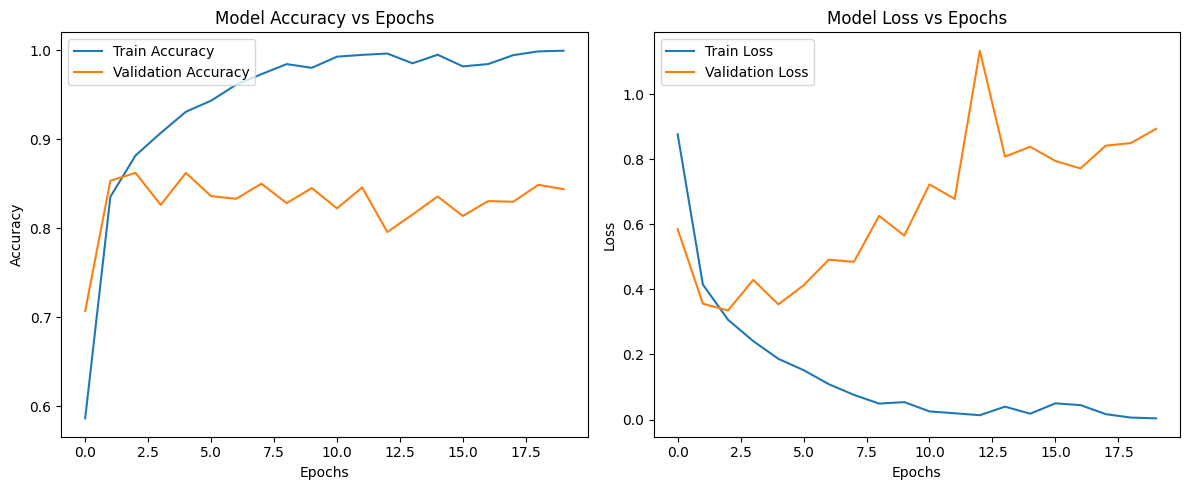

In [22]:
plot_results(history)

# Data Pre-process
X_train: Flatten Positional Data for CNN

- 12212 atoms in train set
- 1202 max AAs (c-a positions)
- 1 is an added spatial dimension for the CNN
- 3 is the (x, y, z) coords
- 1 is the channel dimension

In [23]:
X_train.shape

TensorShape([12212, 1202, 1, 3, 1])

In [24]:
# y_train is still a categorical 3D matrix
np.array(y_train)

array([[0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

y_train

In [56]:
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping

# Simplified model
model = models.Sequential([
    layers.Conv3D(32, kernel_size=(3, 1, 3), activation='relu', padding='same', input_shape=(1202, 1, 3, 1)),
    layers.MaxPooling3D(pool_size=(2, 1, 1), padding='same'),
    layers.Conv3D(64, kernel_size=(3, 1, 3), activation='relu', padding='same'),
    layers.MaxPooling3D(pool_size=(2, 1, 1), padding='same'),  
    layers.Flatten(),
    layers.Dense(3, activation='softmax')  
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Increase max epochs, early stopping will prevent overfitting
    batch_size=128,
    callbacks=[early_stopping]
)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")


Epoch 1/50


/Users/jairusmartinez/Desktop/martinez_jairus_protein_4531/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



96/96 ━━━━━━━━━━━━━━━━━━━━ 64s 663ms/step - accuracy: 0.4029 - loss: 1.1839 - val_accuracy: 0.6711 - val_loss: 0.7636
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 64s 662ms/step - accuracy: 0.7128 - loss: 0.6628 - val_accuracy: 0.7760 - val_loss: 0.5032
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 65s 676ms/step - accuracy: 0.8358 - loss: 0.4138 - val_accuracy: 0.8434 - val_loss: 0.3901
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 68s 710ms/step - accuracy: 0.8809 - loss: 0.3261 - val_accuracy: 0.8592 - val_loss: 0.3501
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 66s 685ms/step - accuracy: 0.9055 - loss: 0.2472 - val_accuracy: 0.8293 - val_loss: 0.4116
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 68s 708ms/step - accuracy: 0.9204 - loss: 0.2220 - val_accuracy: 0.8611 - val_loss: 0.3587
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8388 - loss: 0.3966
Test accuracy: 0.8556
Test loss: 0.3735


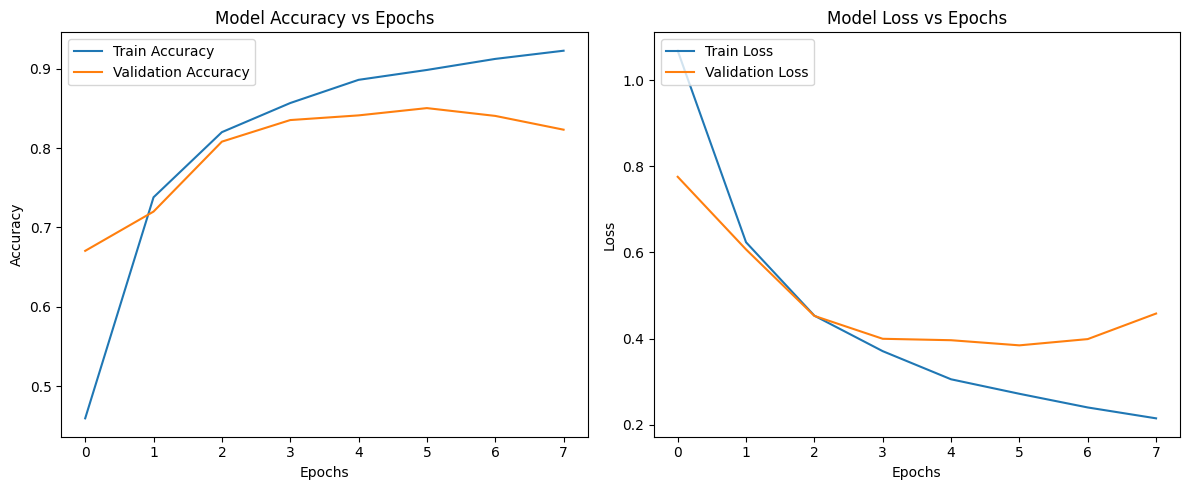

In [26]:
plot_results(history)

In [27]:
tf.keras.models.save_model(model=model,filepath='final_model.keras')

# Output
- 3D Matrix where each row as an array of length 3 containing the predicted probability at the index that corresponds to the class label

In [44]:
def create_prediction_artifacts(model: Sequential, X: tf.Tensor, y: tf.Tensor):
    """
    Returns predicted artifacts from Sequential 
    keras CNN model. 
    Args:
        model (keras.Sequential): Trained Keras sequential model
        X (tf.Tensor): Tensor containing 3D protein input data
        y (tf.Tensor): Tensor containing 3D protein class labels       
    Returns:
        raw_predictions (np.ndarray): Raw predictions
        y_pred (np.ndarray): Array containing predictions
        df_results_int (pd.DataFrame): Data frame containing predicted/true class labels as integers
        df_results_str (pd.DataFrame): Data frame containing predicted/true class labels as strings
    """
    raw_predictions = model.predict(X)

    y_pred = np.argmax(raw_predictions, axis=1)
    y_true = np.argmax(y, axis=1)

    df_results_int = pd.DataFrame({
            'y_true': y_true,
            'y_pred': y_pred
        })
    
    df_results_int = df_results_int.assign(
        is_equal=lambda x: x['y_true'] == x['y_pred']
    )
    
    df_results_str = df_results_int.replace({0: 'Mainly Alpha', 1: 'Mainly Beta', 2: 'Alpha-Beta'}, inplace=False)

    df_results_str = df_results_str.assign(
        is_equal=lambda x: x['y_true'] == x['y_pred']
    )

    return raw_predictions, y_pred, df_results_int, df_results_str

In [50]:
loaded_model = tf.keras.models.load_model('final_model.keras')

raw_predictions, y_pred, df_results_int, df_results_str = create_prediction_artifacts(loaded_model, X_test, y_test)

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [51]:
raw_predictions

array([[9.8629028e-01, 3.7460134e-07, 1.3709343e-02],
       [2.4514635e-01, 6.0399100e-03, 7.4881381e-01],
       [3.2012388e-02, 5.2995253e-01, 4.3803513e-01],
       ...,
       [2.7216394e-02, 5.5677067e-02, 9.1710651e-01],
       [4.7703334e-03, 7.4607158e-01, 2.4915805e-01],
       [7.8728510e-05, 8.8655406e-01, 1.1336725e-01]], dtype=float32)

In [52]:
df_results_str

,y_true,y_pred,is_equal
0,Mainly Alpha,Mainly Alpha,True
1,Alpha-Beta,Alpha-Beta,True
2,Alpha-Beta,Mainly Beta,False
3,Mainly Beta,Alpha-Beta,False
4,Mainly Alpha,Mainly Alpha,True
...,...,...,...
1692,Mainly Alpha,Mainly Alpha,True
1693,Mainly Alpha,Mainly Alpha,True
1694,Alpha-Beta,Alpha-Beta,True
1695,Alpha-Beta,Mainly Beta,False


In [53]:
df_results_str['is_equal'].value_counts(normalize=True)

is_equal
True     0.886859
False    0.113141
Name: proportion, dtype: float64

In [55]:
cm = confusion_matrix(df_results_int['y_true'], df_results_int['y_pred'])
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[519   3  13]
 [  6 507  73]
 [ 38  59 479]]


## Confused ;) Matrix Structure

- Rows are the actual classes
- Cols are the predicted classes
- Rrder is typically 0 (Mainly Alpha) > 1 (Mainly Beta) > 2 (Alpha-Beta)

1. Diagonal elements represent correct classifications for each class.
2. Off-diagonal elements represent misclassifications.
3. Class 0 has the highest number of correct classifications.
4. The model seldom confuses Mainly Alpha and Mainly Beta.
5. There's some confusion between Mainly Beta and Alpha-Beta.
6. Alpha-Beta is most often misclassified as Mainly Beta.

Overall, the model performs well, with high accuracy and good separation between classes, especially between Mainly Alpha and the others. The main area for potential improvement is in distinguishing between Mainly Beta and Alpha Beta.

# Reverse CNN Transform and Plot 3D Predictions with Correct Labels

In [34]:
def reverse_transform(X: tf.Tensor, y: tf.Tensor):
    """
    Reverses the CNN-specific transforms done to the original 
    protein numpy data format and shape.
    Args:
        X (tf.Tensor): Protein data of shape,  TensorShape([len(X), 1202, 1, 3, 1])
        y (tf.Tensor): Secondary structure labels of shape,  TensorShape([len(X), 3])
    Returns:
        X (np.ndarray): Shape (len(X), 1202, 3)
        y (np.ndarray): Shape (len(X), 1)
    """
    # reverse X 
    X_squeezed = tf.squeeze(X, axis=2) # remove added channel dimension
    X_original = tf.squeeze(X_squeezed, axis=-1) # remove added spatial dimension
    X_numpy = X_original.numpy() # conver tensor to np array

    # reverse Y
    y_original = tf.argmax(y, axis=-1) + 1
    y_original = tf.expand_dims(y_original, axis=-1)
    y_numpy = y_original.numpy()

    return X_numpy, y_numpy

In [35]:
X_test_np, y_test_np = reverse_transform(X_test, y_test)

In [36]:
plot_proteins(num_protein=3, protein_positions=X_test_np, protein_lables=y_test_np, predicted_label=y_pred)